In [1]:
import nltk
from nltk.corpus import brown
from tqdm.notebook import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt
nltk.download('brown')
nltk.download('universal_tagset')

np.random.seed(2003)

In [2]:
def shuffle(X, Y):
    N = X.shape[0]
    idx = np.arange(N)
    np.random.shuffle(idx)
    return X[idx], Y[idx]

def add_ones(X):
    ones = np.ones((X.shape[0], 1))
    return np.append(X, ones, axis=1)

def get_batches(X, Y, batch=32):
    N = X.shape[0]
    X_batch, Y_batch = [], []
    Q, R = N // batch, N % batch
    for i in range(Q):
        X_batch.append(X[i*batch:(i+1)*batch, :])
        Y_batch.append(Y[i*batch:(i+1)*batch])
    if R != 0 :
        X_batch.append(X[Q*batch:, :])
        Y_batch.append(Y[Q*batch:])
    return X_batch, Y_batch

def split_util(X, train_ratio=0.8):
    slic = int(X.shape[0] * min(max(train_ratio, 0.0), 1.0))
    X_train, X_test = X[:slic], X[slic:]
    return X_train, X_test

def split_data(X, Y, train_ratio=0.8):
    X_train, X_test = split_util(X, train_ratio)
    Y_train, Y_test = split_util(Y, train_ratio)
    return X_train, Y_train, X_test, Y_test

def one_hot_encode(X, labels):
    X.shape = (X.shape[0], 1)
    newX = np.zeros((X.shape[0], len(labels)))
    label_encoding = {}
    for i, l in enumerate(labels):
        label_encoding[l] = i
    for i in range(X.shape[0]):
        newX[i, label_encoding[X[i, 0]]] = 1
    return newX

def normalize(X):
    return (X - np.mean(X)) / np.std(X)

def untag(tagged_sent):
    return [word for word, tag in tagged_sent]

def preprocess(X, Y):
    N, D = X.shape
    X_new = [np.ones((N, ), dtype=np.float64)]
    for i in range(1, D):
        col = X[:, i]
        try:
            col = col.astype(np.float64)
            new_cols = normalize(col)
            X_new.append(new_cols)
        except ValueError:
            labels = sorted(list(set(col)))
            new_cols = one_hot_encode(col, labels)
            for j in range(new_cols.shape[1]):
                X_new.append(new_cols[:, j])
    X_new = np.array(X_new).T
    return X_new, Y

def visualize(X, Y, W=None):
    fig = plt.figure()
    for i in range(X.shape[0]):
        if Y[i][0] > 0 :
            plt.scatter(X[i][0], X[i][1], marker='+', color='red')
        else :
            plt.scatter(X[i][0], X[i][1], marker='_', color='blue')
    if W is None : return
    xmin, xmax = min(X[:, 0]), max(X[:, 0])
    linex = np.linspace(xmin, xmax, num=50)
    liney = [-(W[2] + W[0] * e) / W[1] for e in linex]
    plt.plot(linex, liney)

def min_max_scale(x):
    mn = np.min(x, axis=0)
    r = np.ptp(x, axis=0)
    mask = (r == 0)
    r[mask] = mn[mask]
    return (x - mn) / r

In [3]:
all_sents = list(brown.tagged_sents(tagset='universal'))
np.random.shuffle(all_sents)
print('Total Sentences : {}'.format(len(all_sents)))
tagset = set()
for sent in all_sents:
    for token, tag in sent:
        tagset.add(tag)
tagset.add('$')
tagset = sorted(list(tagset))
# k Fold cross validation
k = 5
batch_size = len(all_sents) // k

Total Sentences : 57340


In [4]:
class FeatureExtractor():
    def __init__(self, train_sents, test_sents, k=2):
        self.empty_tag = '$'
        self.empty_token = ' <UNK>'
        self.test_sents = test_sents
        self.train_sents = train_sents
        self.wordset = None
        self.wordID = None
        self.tagID = {}
        for i, tag in enumerate(tagset):
            self.tagID[tag] = i
        self.ngram = None
        self.k = k
        self.X = None
        self.Y = None
        
    def get_wordID(self, word):
        if word in self.wordset:
            return self.wordID[word]
        return self.wordID[self.empty_token]
    
    def context(self, i, tagged_sent, token):
        con = []
        for j in range(i - self.k + 1, i):
            if (j < 0) :
                con.append(self.tagID[self.empty_tag])
            else:
                tag = tagged_sent[j][1]
                con.append(self.tagID[tag])
        con.append(self.get_wordID(token))
        return tuple(con)

    def create_vocab(self):
        if self.wordset is not None : 
            return
        self.wordset = set()
        for sent in self.train_sents:
            for word, tag in sent:
                self.wordset.add(word)
        self.wordset.add(self.empty_token)
        self.wordset = sorted(list(self.wordset))
        self.wordID = {}
        for i, word in enumerate(self.wordset):
            self.wordID[word] = i
        self.wordset = set(self.wordset)

    def create_ngrams(self):
        if self.ngram is not None : 
            return
        self.ngram = {}
        for sent in self.train_sents:
            for i in range(len(sent)):
                token, tag = sent[i]
                lcon = list(self.context(i, sent, token))
                for j in range(len(lcon)):
                    con = tuple(lcon[j:])
                    if con not in self.ngram.keys():
                        self.ngram[con] = [0 for i in tagset]
                    self.ngram[con][self.tagID[tag]] += 1
        for key in self.ngram.keys():
            f = self.ngram[key]
            s = 0
            for v in f: s += v
            self.ngram[key] = [v / s for v in f]
                
    def special_features(self, i, sent, token):
        token_feature = {    
            'is_first'          : int(i == 0),
            'is_last'           : int(i == len(sent)-1),
            'is_capitalized'    : int(token[0].upper() == token[0]),
            'is_all_capitalized': int(token.upper() == token),  
            'is_capitals_inside': int(token[1:].lower() != token[1:]),
            'is_numeric'        : any(ch.isdigit() for ch in token),
            'is_money'          : int(token.startswith('$')),
            'ends_with_ly'      : int(token.endswith('ly')),
            'ends_with_ment'    : int(token.endswith('ment')),
            'ends_with_able'    : int(token.endswith('able') or token.endswith('ible')),
            'ends_with_fy'      : int(token.endswith('fy')),
            'ends_with_al'      : int(token.endswith('al')),
        }
        return [token_feature[k] for k in sorted(token_feature.keys())]

    def feature(self, i, sent, token):
        lcon = self.context(i, sent, token)
        feature = [0 for j in tagset]
        feature[7] = 1.0
        for j in range(len(lcon)):
            con = tuple(lcon[j:])
            if con in self.ngram.keys():
                feature = self.ngram[con]
                break
        return feature + self.special_features(i, sent, token)

    def form_data(self):
        self.create_vocab()
        self.create_ngrams()
        if self.X is not None: return
        features, tags = [], []
        tmp = {}
        for sent in tqdm(self.train_sents):
            for token_index, token_pair in enumerate(sent):
                token, tag = token_pair
                feature = self.feature(token_index, sent, token)
                cur = tuple(feature)
                if cur not in tmp.keys():
                    tmp[cur] = [0 for i in tagset]
                tmp[cur][self.tagID[tag]] += 1
                
        for k in tmp.keys():
            cnt = tmp[k]
            mx = max(list(range(len(cnt))), key=lambda x:cnt[x])
            features.append(k) 
            tags.append(mx)
        self.X = np.array(features).astype(np.float64)
        self.Y = np.array(tags)



In [5]:
extractors = []
for i in range(k):
    l = i * batch_size
    r = l + batch_size
    if i == k - 1 : r = len(all_sents)
    test_sents = all_sents[l:r]
    train_sents = all_sents[:l] + all_sents[r:]
    extractors.append(FeatureExtractor(train_sents, test_sents, k=3))
    extractors[-1].form_data()

In [6]:
class SVM_Tagger():
    def __init__(self, extractor, model_name='SVM_Tagger'):
        self.extractor = extractor
        self.name = model_name
        self.Wstates = {}
        self.X = extractor.X
        self.Y = extractor.Y
        self.mn = np.mean(self.X, axis=0)
        self.X = self.tr(self.X)
        N, D = self.X.shape
        C = np.max(self.Y) + 1
        self.W = 0.001 * np.random.standard_normal(size=(D, C))
        
    def tr(self, X):
        X -= self.mn
        return add_ones(X)

    def loss(self, X, Y, reg):
        dW = np.zeros_like(self.W) 
        N, D = X.shape
        scores = np.matmul(X, self.W)

        correct = scores[np.arange(N), Y].reshape(N, 1)
        margin = np.maximum(0, scores - correct + 1)
        margin[np.arange(N), Y] = 0
        loss = np.sum(margin) / N + reg * np.sum(np.square(self.W))

        margin[margin > 0] = 1
        valid_margin_count = np.sum(margin, axis=1)
        margin[np.arange(N), Y] -= valid_margin_count
        dW = np.matmul(X.T, margin) / N + reg * 2 * self.W

        return loss, dW

    def fit(self, lr=0.000001, reg=0.00001, epochs=100, batch=10000, verbose=True, decay=0.9, interval=10, val_size=None):
        if val_size < 0: val_size += len(self.extractor.test_sents) + 1
        loss_history = []
        for epoch in range(epochs):
            loss = 0.0
            X_batches, Y_batches = None, None
            X_batches, Y_batches = get_batches(*shuffle(self.X, self.Y), batch)
            for X_batch, Y_batch in zip(X_batches, Y_batches):
                cur_loss, grad = self.loss(X_batch, Y_batch, reg)
                loss += cur_loss * X_batch.shape[0]
                self.W -= lr * grad
            loss /= self.X.shape[0]
            loss_history.append(loss)
            if epoch % interval == 0:
                lr *= decay
                if val_size is None:
                    if verbose:
                        print('Epoch {}/{} | Loss {:.6f}'.format(epoch, epochs, loss))
                else:
                    acc = self.accuracy(self.extractor.test_sents, val_size)
                    acc = round(acc, 6)
                    if verbose:
                        print('Epoch {}/{} | Loss {:.6f} | Validation Accuracy {}'.format(epoch, epochs, loss, acc))
                    state = 'val_{}_{}'.format(val_size, acc)
                    self.Wstates[state] = np.copy(self.W)
        return loss_history

    def predict(self, X):
        scores = np.matmul(X, self.W)
        y_pred = scores.argmax(axis=1)
        return y_pred
    
    def predict_sent(self, given_sent):
        sent = [(word, '') for word in given_sent]
        for i in range(len(sent)):
            token = sent[i][0]
            f = self.extractor.feature(i, sent, token)
            f = np.array(f).astype(np.float64)
            f = np.expand_dims(f, axis=0)
            f = self.tr(f)
            tag = np.squeeze(self.predict(f))
            sent[i] = (sent[i][0], tagset[tag])
        return sent
    
    def accuracy(self, sents, num=None):
        if num is None: num = len(sents)
        idx = np.random.choice(len(sents), num, replace=False)
        correct, total = 0, 0
        for i in idx:
            pred_sent = self.predict_sent(untag(sents[i]))
            tag_true = np.array([tag for word, tag in sents[i]])
            tag_pred = np.array([tag for word, tag in pred_sent])
            correct += np.sum(tag_true == tag_pred)
            total += len(tag_true)
        return correct / total

    def save(self, min_acc=0.9):
        for k, v in self.Wstates.keys():
            if k >= min_acc:
                np.save(self.name + '_({}).npy'.format(k), v)
    
    def load(self, path):
        self.W = np.load(path)
        
    def set_best(self):
        if not self.Wstates.keys(): return
        best_W, best_acc = 0, 0
        for key in self.Wstates.keys():
            acc = float(key.split('_')[-1])
            if best_acc < acc:
                best_acc = acc
                best_W = np.copy(self.Wstates[key])
        self.W = np.copy(best_W)
        
    def get_labels(self):
        y_true, y_pred = [], []
        for sent in self.extractor.test_sents:
            pred_sent = self.predict_sent(untag(sent))
            for i in range(len(sent)):
                y_true.append(sent[i][1])
                pred = pred_sent[i][1]
                if pred == '$' : pred = 'X'
                y_pred.append(pred)
        return np.array(y_true), np.array(y_pred)


In [7]:
models = []
losses = {}
for i in range(k):
    model_name = 'SVM_Tagger_{}'.format(i + 1)
    models.append(SVM_Tagger(extractors[i], model_name))

In [8]:
import pickle

def save_states(path='weights.pickle'):
    states = []
    for model in models:
        states.append(model.Wstates)
    with open(path, 'wb') as ff:
        pickle.dump(states, ff, pickle.HIGHEST_PROTOCOL)
        
# load presaved states
def load_states(path='weights.pickle'):
    with open(path, 'rb') as ff:
        states = pickle.load(ff)
    for i in range(k):
        models[i].Wstates = states[i]

# save_states()
# load_states()

# for i in range(k):
#     models[i].set_best()

In [9]:
train_models = list(range(k))
for i in train_models:
    name = models[i].name
    print('Model : {}'.format(name))
    tot = len(models[i].extractor.test_sents)
    if name not in losses.keys():
        losses[name] = []
    if losses[name]: 
        print('Previous Loss : {:.6f}'.format(losses[name][-1]))
    losses[name] += models[i].fit(
        lr = 1e-2, 
        reg = 1e-4, 
        epochs = 40, 
        batch = 100, 
        verbose = True, 
        decay = 1.0, 
        interval = 2, 
        val_size = 100 # len(models[i].extractor.test_sents)
    )
    print('Final Loss : {:.6f}'.format(losses[name][-1]))

Model : SVM_Tagger_1
Epoch 0/40 | Loss 10.157931 | Validation Accuracy 0.448608
Epoch 2/40 | Loss 4.486650 | Validation Accuracy 0.462354
Epoch 4/40 | Loss 3.136724 | Validation Accuracy 0.743486
Epoch 6/40 | Loss 2.366885 | Validation Accuracy 0.724204
Epoch 8/40 | Loss 1.854441 | Validation Accuracy 0.799518
Epoch 10/40 | Loss 1.498318 | Validation Accuracy 0.784261
Epoch 12/40 | Loss 1.241819 | Validation Accuracy 0.817808
Epoch 14/40 | Loss 1.051899 | Validation Accuracy 0.825603
Epoch 16/40 | Loss 0.901457 | Validation Accuracy 0.830669
Epoch 18/40 | Loss 0.780050 | Validation Accuracy 0.947368
Epoch 20/40 | Loss 0.686202 | Validation Accuracy 0.945973
Epoch 22/40 | Loss 0.610485 | Validation Accuracy 0.94674
Epoch 24/40 | Loss 0.549072 | Validation Accuracy 0.947419
Epoch 26/40 | Loss 0.500295 | Validation Accuracy 0.943041
Epoch 28/40 | Loss 0.461602 | Validation Accuracy 0.952941
Epoch 30/40 | Loss 0.429617 | Validation Accuracy 0.944606
Epoch 32/40 | Loss 0.403379 | Validation

In [10]:
y_trues, y_preds = [], []
for i in range(k):
    y_true, y_pred = models[i].get_labels()
    y_trues.append(y_true)
    y_preds.append(y_pred)
    acc = round(np.sum(y_true == y_pred) / y_true.shape[0], 6)
    state = 'val_{}_{}'.format(len(models[i].extractor.test_sents), acc)
    models[i].Wstates[state] = np.copy(models[i].W)
    print(models[i].name + ' Accuracy : {:.2f} %'.format(100 * acc))

SVM_Tagger_1 Accuracy : 95.26 %
SVM_Tagger_2 Accuracy : 95.28 %
SVM_Tagger_3 Accuracy : 95.43 %
SVM_Tagger_4 Accuracy : 95.25 %
SVM_Tagger_5 Accuracy : 95.24 %


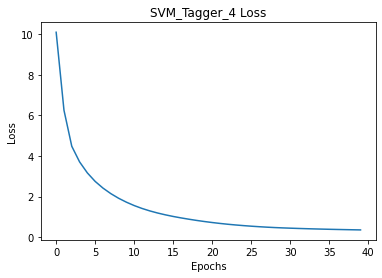

In [11]:
id = 3
plt.plot(losses[models[id].name])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(models[id].name + ' Loss')
plt.show()

In [12]:
# Metric analysis functions
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def get_report(y_true, y_pred, classes):
    clf_report = classification_report(y_true, y_pred, labels=classes, zero_division=0)
    clf_report = clf_report.replace('\n\n', '\n')
    clf_report = clf_report.replace('micro avg', 'micro_avg')
    clf_report = clf_report.replace('macro avg', 'macro_avg')
    clf_report = clf_report.replace('weighted avg', 'weighted_avg')
    clf_report = clf_report.replace(' / ', '/')
    lines = clf_report.split('\n')

    class_names, plotMat, support = [], [], []
    for line in lines[1:]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        v = [float(x) for x in t[1: len(t) - 1]]
        if len(v) == 1 : v = v * 3
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)
    plotMat = np.array(plotMat)
    support = np.array(support)
    return class_names, plotMat, support

def get_scores(y_true, y_pred, classes):
    correct, wrong = {}, {}
    for tag in classes:
        correct[tag] = 0
        wrong[tag] = 0
        
    for tag, pred in zip(y_true, y_pred):
        if tag == pred:
            correct[tag] += 1
        else:
            wrong[tag] += 1
            
    scores = []
    total = len(y_true)
    for tag in classes:
        cur = np.array([correct[tag], wrong[tag]])
        scores.append(cur / total)
    return np.array(scores)
    
def plot_confusion_matrix(classes, mat, normalize=True, cmap=plt.cm.Blues):
    cm = np.copy(mat)
    title = 'Confusion Matrix (without normalization)'
    if normalize:
        cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
        title = title.replace('without', 'with')
    plt.clf()    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = np.max(cm) / 2
    thresh = 1 / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if (cm[i, j] > thresh) else "black"
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color=color)
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches="tight", transparent=True)
    
def plot_clf_report(classes, plotMat, support, cmap=plt.cm.Blues):
    title = 'Classification Report'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(classes[idx], sup) for idx, sup in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=0)
    plt.yticks(np.arange(len(classes)), yticklabels)
    thresh = np.max(plotMat) / 2
    thresh = 1 / 2
    for i in range(plotMat.shape[0]):
        for j in range(plotMat.shape[1]):
            color = "white" if (plotMat[i, j] > thresh) else "black"
            plt.text(j, i, format(plotMat[i, j], '.2f'), horizontalalignment="center", color=color, fontsize=14)

    plt.xlabel('Metrics',fontsize=22)
    plt.ylabel('Classes',fontsize=22)
    plt.tight_layout()
    plt.savefig('classification_report.png', bbox_inches="tight", transparent=True)
    
def plot_tag_scores(classes, scores, normalize=True):
    plt.clf()
    width = 0.45
    fig, ax = plt.subplots(figsize=(20,10))
    ax.xaxis.set_tick_params(labelsize=18, rotation=25)
    ax.yaxis.set_tick_params(labelsize=18)
    range_bar1 = np.arange(len(classes))
    rects1 = ax.bar(range_bar1, tuple(scores[:, 0]), width, color='b')
    rects2 = ax.bar(range_bar1 + width, tuple(scores[:, 1]), width, color='r')

    ax.set_ylabel('Scores',fontsize=22)
    ax.set_title('Tag scores', fontsize=22)
    ax.set_xticks(range_bar1 + width / 2)
    ax.set_xticklabels(classes)

    ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'), fontsize=20)
    plt.legend()
    plt.savefig('tag_scores.png', bbox_inches="tight", transparent=True)
    plt.show()

In [13]:
# average your cm, report, score and support variables over k runs
classes = tagset[1:]
class_names = None
report = None
support = None
cm, scores = None, None
cnt = 0
for y_true, y_pred in zip(y_trues, y_preds):
    class_names, report_, support_ = get_report(y_true, y_pred, classes)
    cm_ = confusion_matrix(y_true, y_pred, labels=classes)
    scores_ = get_scores(y_true, y_pred, classes)
    
    if report is None : report = np.zeros_like(report_, dtype=np.float64)
    report += report_
    
    if support is None : support = np.zeros_like(support_, dtype=np.float64)
    support += support_
    
    if cm is None : cm = np.zeros_like(cm_, dtype=np.float64)
    cm += cm_
    
    if scores is None : scores = np.zeros_like(scores_, dtype=np.float64)
    scores += scores_
    
    cnt += 1
    
report /= cnt
support /= cnt
cm /= cnt
scores /= cnt

<Figure size 432x288 with 0 Axes>

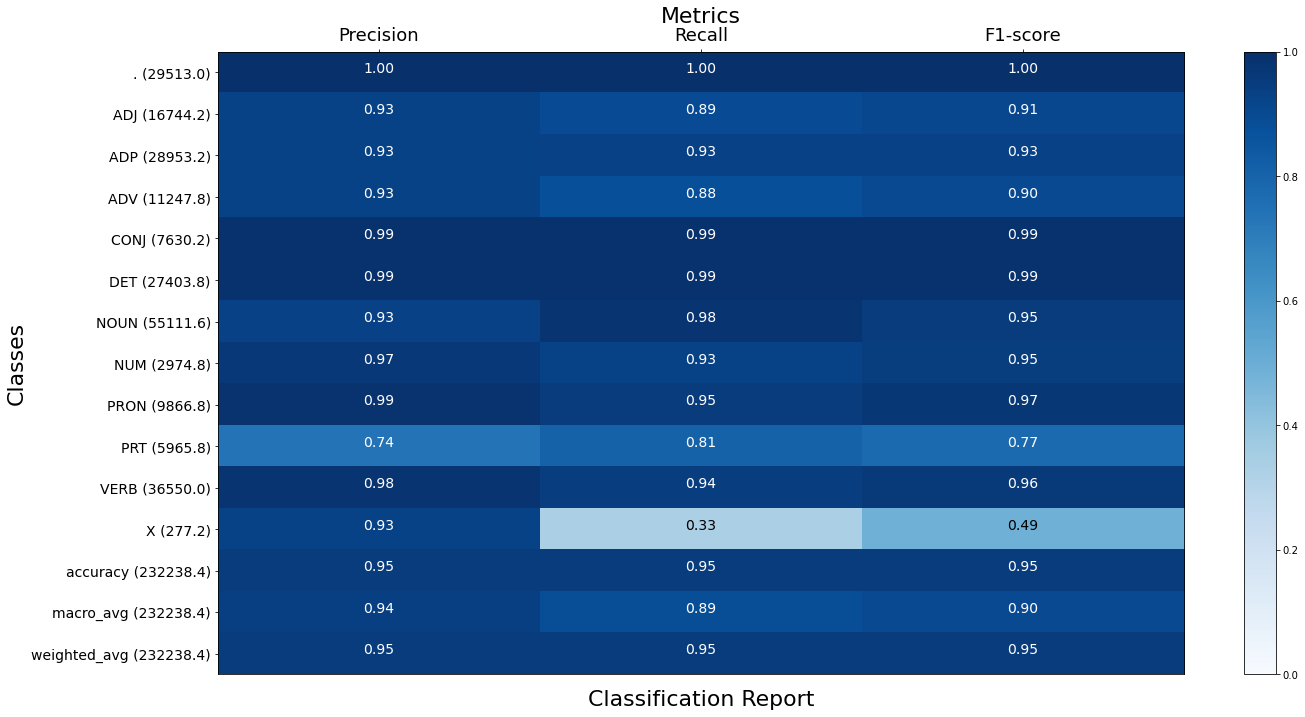

In [14]:
plot_clf_report(class_names, report, support)

<Figure size 432x288 with 0 Axes>

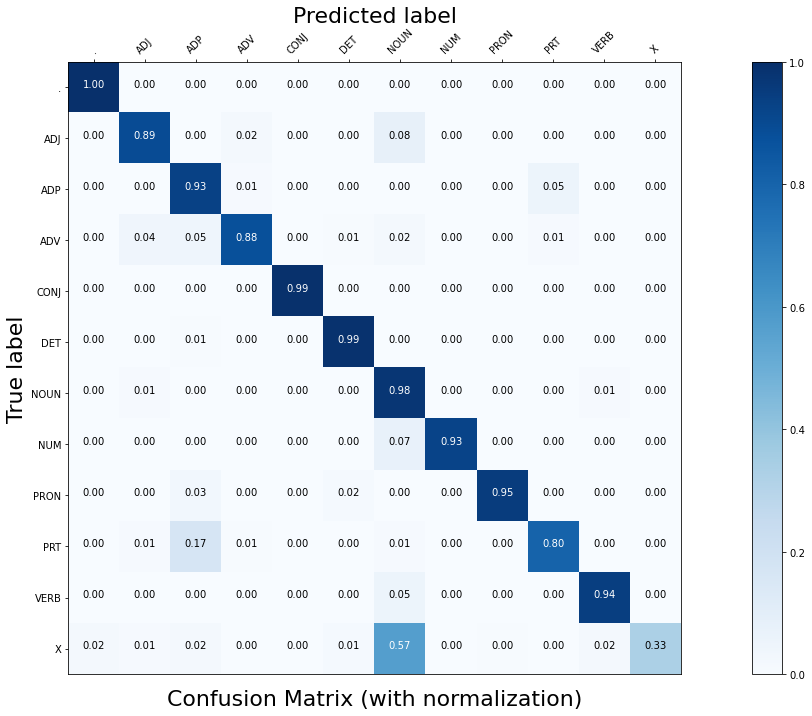

In [15]:
plot_confusion_matrix(classes, cm)

<Figure size 432x288 with 0 Axes>

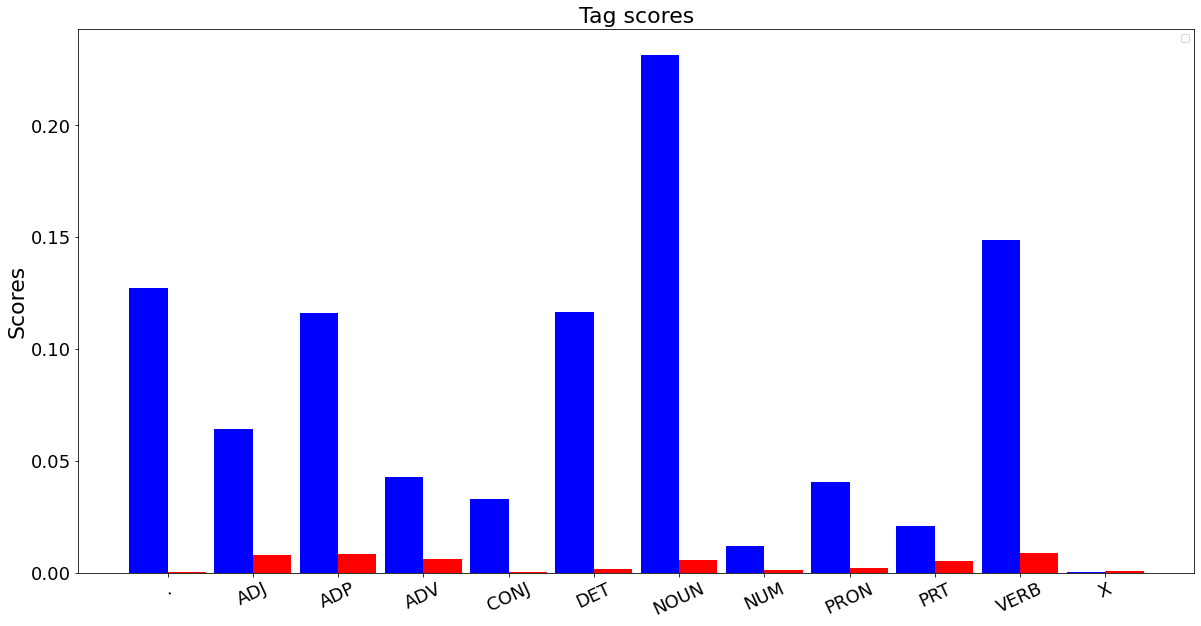

In [16]:
plot_tag_scores(classes, scores)

In [18]:
# slight error analysis
idx = 0
test_sent_set = models[idx].extractor.test_sents
test_pred = []
for sent in test_sent_set:
    pred_sent = models[idx].predict_sent(untag(sent))
    test_pred.append(pred_sent)

In [29]:
from collections import defaultdict, Counter
mistags = defaultdict(Counter)
mistag_cnt = Counter()
for i in range(len(test_pred)):
    for j in range(len(test_pred[i])):
        if test_pred[i][j][1] == test_sent_set[i][j][1]:
            continue
        word, pred = test_pred[i][j]
        word, actual = test_sent_set[i][j]
        mistags[word][(actual, pred)] += 1
        mistag_cnt[word] += 1

In [33]:
for word, cnt in mistag_cnt.most_common(100):
    print(word, cnt, dict(mistags[word]))

to 2011 {('ADP', 'PRT'): 1333, ('PRT', 'ADP'): 676, ('ADV', 'PRT'): 1, ('X', 'ADP'): 1}
that 659 {('DET', 'ADP'): 228, ('ADP', 'PRON'): 69, ('PRON', 'ADP'): 306, ('ADV', 'DET'): 1, ('ADP', 'DET'): 32, ('ADV', 'ADP'): 10, ('PRON', 'DET'): 7, ('DET', 'PRON'): 6}
as 261 {('ADV', 'ADP'): 186, ('ADP', 'ADV'): 75}
her 186 {('PRON', 'DET'): 119, ('DET', 'PRON'): 67}
more 130 {('ADJ', 'ADV'): 99, ('ADV', 'ADJ'): 31}
on 119 {('PRT', 'ADP'): 116, ('ADP', 'PRT'): 3}
in 97 {('PRT', 'ADP'): 95, ('X', 'ADP'): 2}
so 92 {('ADV', 'ADP'): 43, ('ADP', 'ADV'): 49}
one 90 {('NOUN', 'NUM'): 73, ('NUM', 'NOUN'): 17}
out 89 {('ADP', 'PRT'): 57, ('PRT', 'ADP'): 31, ('DET', 'ADP'): 1}
over 75 {('PRT', 'ADP'): 57, ('ADP', 'PRT'): 18}
about 75 {('ADV', 'ADP'): 47, ('ADP', 'ADV'): 26, ('PRT', 'ADP'): 1, ('PRT', 'ADV'): 1}
such 70 {('ADJ', 'PRT'): 6, ('PRT', 'ADJ'): 59, ('ADV', 'ADJ'): 3, ('ADJ', 'ADV'): 2}
much 63 {('ADV', 'ADJ'): 31, ('ADJ', 'ADV'): 32}
there 62 {('ADV', 'PRT'): 43, ('PRT', 'ADV'): 19}
like 51 {(

In [26]:
# requirements
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}>={}".format(*r))

tqdm>=4.45.0
scikit-learn>=0.23.2
numpy>=1.18.5
nltk>=3.2.4
matplotlib>=3.2.1
